In [1]:
import json
import pandas as pd
import numpy as np
import re
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import matplotlib.pyplot as mtp

In [2]:
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding

import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [3]:
tweets = []
for line in open('tweets.json', 'r'):
    tweets.append(json.loads(line))

In [4]:
regex = r"(?i)\bSave\s*QAU\b"
author_id = []
tweet_text = []
for tweet in tweets:
    for t in tweet['data']:
        match = re.search(regex, t['text'])
        if match:
            author_id.append(t['author_id'])
            tweet_text.append(t['text'])
print(len(author_id))
print(len(tweet_text))

13000
13000


In [5]:
dict = {'author_id': author_id, 'tweet_text': tweet_text}  
       
df = pd.DataFrame(dict) 

df.to_csv('tweets.csv', index=False) 

In [6]:
df = pd.read_csv("tweets.csv")

In [7]:
df

,author_id,tweet_text
0,1090482864263712769,تاریخ میں لکھ جاۓ گا کے تھوڑی سی ترقی اور پیسو...
1,1093938062193819650,So thanks Sir ...
2,1362581000652398592,"Although,Officially i don't belong here, but #..."
3,1093938062193819650,#QAUbleeds #SaveQAU https://t.co/D23yK0igCw
4,1266331655721156608,To Save QAU from the land grabbing mafia there...
...,...,...
12995,212129844,@IlhanNiaz Do we have system? Where is governm...
12996,709147229781696513,We condemn and oppose the ongoing evictions of...
12997,709144305852653568,We condemn and oppose the ongoing evictions of...
12998,708377144406249476,We condemn and oppose the ongoing evictions of...


In [8]:
# Download the stopwords and punkt resources
# nltk.download('stopwords')
# nltk.download('punkt')

def preprocess_tweet(tweet):
    # Remove RT, hashtags, @mentions, and URLs
    tweet = re.sub(r'^RT', '', tweet) # remove RT prefix
    tweet = re.sub(r'#\S+', '', tweet)
    tweet = re.sub(r'@\S+', '', tweet)
    tweet = re.sub(r'http\S+', '', tweet)
    
    # Convert to lowercase
    tweet = tweet.lower()
    
    # Remove punctuation
    tweet = re.sub(r'[^\w\s]', '', tweet)
    
    # Tokenize the tweet
    tokens = nltk.word_tokenize(tweet)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    # Stem the tokens
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    
    # Concatenate the tokens into a single string
    preprocessed_tweet = ' '.join(stemmed_tokens)
    
    return preprocessed_tweet

In [9]:
df['preprocessed_tweet'] = df['tweet_text'].apply(preprocess_tweet)

In [10]:
# Remove leading and trailing whitespace from the tweets
df['preprocessed_tweet'] = df['preprocessed_tweet'].str.strip()

# Replace multiple consecutive spaces with a single space
df['preprocessed_tweet'] = df['preprocessed_tweet'].str.replace(r'\s+', ' ')
df

C:\Users\abdul\AppData\Local\Temp\ipykernel_1336\3991143595.py:5: FutureWarning:

The default value of regex will change from True to False in a future version.



,author_id,tweet_text,preprocessed_tweet
0,1090482864263712769,تاریخ میں لکھ جاۓ گا کے تھوڑی سی ترقی اور پیسو...,تاریخ میں لکھ جاۓ گا کے تھوڑی سی ترقی اور پیسو...
1,1093938062193819650,So thanks Sir ...,thank sir unit stand divid fall
2,1362581000652398592,"Although,Officially i don't belong here, but #...",althoughoffici dont belong belong barakahu byp...
3,1093938062193819650,#QAUbleeds #SaveQAU https://t.co/D23yK0igCw,
4,1266331655721156608,To Save QAU from the land grabbing mafia there...,save qau land grab mafia strike tomorrow qsf t...
...,...,...,...
12995,212129844,@IlhanNiaz Do we have system? Where is governm...,system govern
12996,709147229781696513,We condemn and oppose the ongoing evictions of...,condemn oppos ongo evict hut quaidiazam univer...
12997,709144305852653568,We condemn and oppose the ongoing evictions of...,condemn oppos ongo evict hut quaidiazam univer...
12998,708377144406249476,We condemn and oppose the ongoing evictions of...,condemn oppos ongo evict hut quaidiazam univer...


In [11]:
# Define a custom function to concatenate the tweets of the same author
def concatenate_tweets(group):
    author_id = group['author_id'].iloc[0]
    tweets = ' '.join(group['preprocessed_tweet'])
    return pd.Series({'author_id': author_id, 'concatenated_tweets': tweets})

# Group the DataFrame by the author ID and apply the concatenate_tweets function
newdf = df.groupby('author_id').apply(concatenate_tweets)

In [12]:
newdf.to_csv('concattweets.csv', index=False) 

In [13]:
newdf = pd.read_csv("concattweets.csv")

In [14]:
# Create the bag of words model
vectorizer = CountVectorizer()
bow_matrix = vectorizer.fit_transform(newdf['concatenated_tweets'].values.astype('str'))

In [15]:
bow_array = bow_matrix.toarray()

In [16]:
bowdf = pd.DataFrame(bow_array, columns =vectorizer.get_feature_names_out())

In [17]:
newdf

,author_id,concatenated_tweets
0,16064982,sad news actual embarrass
1,25061519,thank
2,27290104,sc take notic qau land grab
3,29607750,wasim khan gilgit baltistan ajk gb
4,33150283,polic call qau campu arrest peac student prote...
...,...,...
2198,1594299805106425857,NaN
2199,1594300201996517378,politician tri take qau help save qau stop bar...
2200,1594300334968651778,NaN
2201,1594347002258653184,save qau save qau start allow cda took land wa...


In [18]:
authors = np.arange(1, 2204)

In [19]:
authors

array([   1,    2,    3, ..., 2201, 2202, 2203])

In [20]:
bowdf.insert(loc=0, column='author_id', value=authors)

In [21]:
bowdf

,author_id,003004,01,013004,03002255606,03008717606,063004,073004,10,100,...,𝐈𝐧,𝐊𝐚𝐡𝐮,𝐌𝐞𝐚𝐧𝐢𝐧𝐠,𝐍𝐚𝐦𝐞,𝐍𝐨,𝐑𝐞𝐥𝐢𝐠𝐢𝐨𝐧,𝐒𝐚𝐲,𝐓𝐨,𝐕𝐢𝐬𝐢𝐭,𝐬𝐭𝐨𝐩
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2198,2199,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2199,2200,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2200,2201,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2201,2202,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
bowdf.to_csv("bow.csv", index=False)

In [23]:
authors = bowdf['author_id']

In [24]:
for col in bowdf.columns:
    if not col.isalpha():
        bowdf = bowdf.drop(col, axis = 1)

In [25]:
bowdf

,aai,aamilah,aap,aapko,ab,abandon,abduct,abdul,abid,abilitiesampenergi,...,𝐈𝐧,𝐊𝐚𝐡𝐮,𝐌𝐞𝐚𝐧𝐢𝐧𝐠,𝐍𝐚𝐦𝐞,𝐍𝐨,𝐑𝐞𝐥𝐢𝐠𝐢𝐨𝐧,𝐒𝐚𝐲,𝐓𝐨,𝐕𝐢𝐬𝐢𝐭,𝐬𝐭𝐨𝐩
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2200,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2201,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
x = bowdf.values

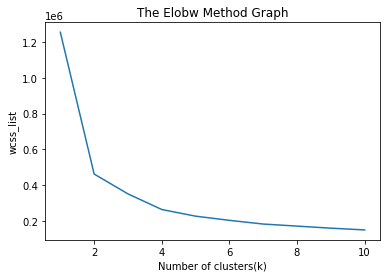

In [27]:
#finding optimal number of clusters using the elbow method
wcss_list= []  #Initializing the list for the values of WCSS  
  
#Using for loop for iterations from 1 to 10.  
for i in range(1, 11):  
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state= 42)  
    kmeans.fit(x)  
    wcss_list.append(kmeans.inertia_)  
mtp.plot(range(1, 11), wcss_list)  
mtp.title('The Elobw Method Graph')  
mtp.xlabel('Number of clusters(k)')  
mtp.ylabel('wcss_list')  
mtp.show()  

The above graph shows that the optimal number of clusters are 4

In [28]:
#training the K-means model on a dataset  
kmeans = KMeans(n_clusters=4, init='k-means++', random_state= 42)  
y_predict= kmeans.fit_predict(x)

In [29]:
bowdf["cluster"] = y_predict

In [30]:
bowdf

,aai,aamilah,aap,aapko,ab,abandon,abduct,abdul,abid,abilitiesampenergi,...,𝐊𝐚𝐡𝐮,𝐌𝐞𝐚𝐧𝐢𝐧𝐠,𝐍𝐚𝐦𝐞,𝐍𝐨,𝐑𝐞𝐥𝐢𝐠𝐢𝐨𝐧,𝐒𝐚𝐲,𝐓𝐨,𝐕𝐢𝐬𝐢𝐭,𝐬𝐭𝐨𝐩,cluster
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2200,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2201,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [31]:
#PCA with two principal components
pca_2d = PCA(n_components=2)

In [32]:
#This DataFrame contains the two principal components that will be used
#for the 2-D visualization mentioned above
PCs_2d = pd.DataFrame(pca_2d.fit_transform(bowdf.drop(["cluster"], axis=1)))

In [33]:
#"PC2_2d" means: 'The second principal component of the components created for 2-D visualization, by PCA.'
PCs_2d.columns = ["PC1_2d", "PC2_2d"]
PCs_2d

,PC1_2d,PC2_2d
0,-0.861430,-2.466882
1,-0.860154,-2.457318
2,-0.839862,-1.696549
3,-0.861575,-2.475294
4,-0.799482,-1.256399
...,...,...
2198,-0.861907,-2.484590
2199,-0.821353,-0.320949
2200,-0.861907,-2.484590
2201,1.732561,103.899217


In [34]:
bowdf = pd.concat([bowdf,PCs_2d], axis=1, join='inner')

In [35]:
bowdf

,aai,aamilah,aap,aapko,ab,abandon,abduct,abdul,abid,abilitiesampenergi,...,𝐍𝐚𝐦𝐞,𝐍𝐨,𝐑𝐞𝐥𝐢𝐠𝐢𝐨𝐧,𝐒𝐚𝐲,𝐓𝐨,𝐕𝐢𝐬𝐢𝐭,𝐬𝐭𝐨𝐩,cluster,PC1_2d,PC2_2d
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.861430,-2.466882
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.860154,-2.457318
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.839862,-1.696549
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.861575,-2.475294
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.799482,-1.256399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.861907,-2.484590
2199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.821353,-0.320949
2200,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.861907,-2.484590
2201,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1.732561,103.899217


In [36]:
cluster0 = bowdf[bowdf["cluster"] == 0]
cluster1 = bowdf[bowdf["cluster"] == 1]
cluster2 = bowdf[bowdf["cluster"] == 2]
cluster3 = bowdf[bowdf["cluster"] == 3]

In [37]:
init_notebook_mode(connected=True)

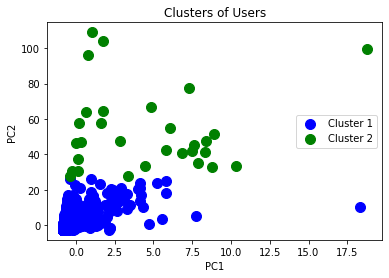

In [38]:
#visulaizing the clusters  
mtp.scatter(cluster0["PC1_2d"], cluster0["PC2_2d"], s = 100, c = 'blue', label = 'Cluster 1') #for first cluster  
mtp.scatter(cluster1["PC1_2d"], cluster1["PC2_2d"], s = 100, c = 'green', label = 'Cluster 2') #for second cluster  
# mtp.scatter(cluster2["PC1_2d"], cluster2["PC2_2d"], s = 100, c = 'red', label = 'Cluster 3') #for third cluster  
# mtp.scatter(cluster3["PC1_2d"], cluster3["PC2_2d"], s = 100, c = 'cyan', label = 'Cluster 4') #for fourth cluster    
mtp.title('Clusters of Users')  
mtp.xlabel('PC1')  
mtp.ylabel('PC2')  
mtp.legend()  
mtp.show()